## Karplus-Strong Algorithm to generate notes

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

We set the sampling frequency which will later be used to play audio.

In [3]:
Fs = 16000 # 16 KHz sampling rate

The above sampling frequency means that, there would be 16000 samples of data per second.

In Karplus-Strong (K-S) Algorithm, the period of the output signal is the length of the input finite signal. Say, if we have 50 samples in the input signal, then frequecy will be $f = F_s / M$, i.e, 16000/50, which would be $320 Hz$. 

Now let us choose an input signal with random values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


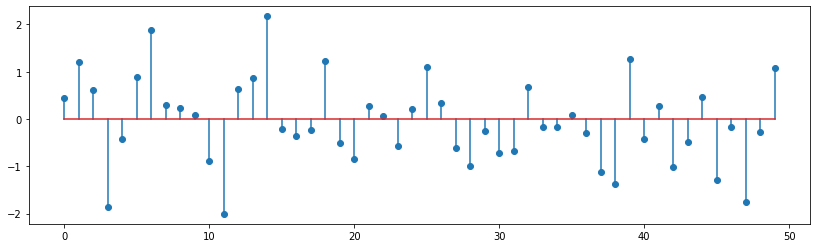

In [4]:
x_n = np.random.randn(50)
plt.stem(x_n);

Now let us define a function which returns output signal generated using K-S algorithm. Here we define the total number of output data points, as in theory, K-S algorithm generates infinite signal.

In [5]:
def KS(x, N, alpha=1):
    M = len(x)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if (n - M) >= 0 else 0)
    return y

In [6]:
y = KS(x_n, Fs * 2)  # Fs * 2 will generate two seconds worth of data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


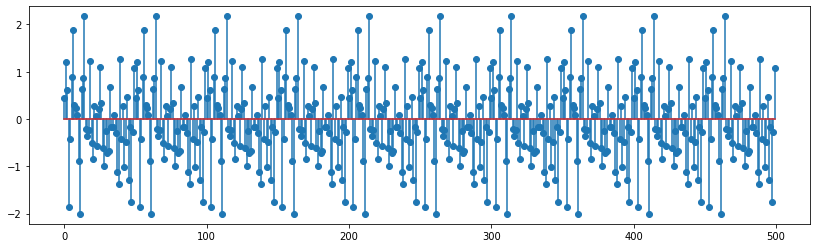

In [7]:
plt.stem(y[0:500]);  # Cause plotting the whole sequence would hang my device and plot would look clumsy

In [8]:
IPython.display.Audio(y, rate=Fs)

Now let us generate the output signal with some dampening effect. Let us provide $$\alpha = 0.99$.

In [9]:
y = KS(x_n, Fs * 2, alpha=0.99)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


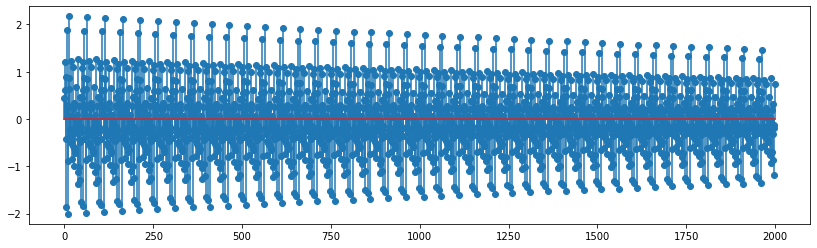

In [10]:
plt.stem(y[0:2000]);

One can observe the dampening amplitude above.

In [11]:
IPython.display.Audio(y, rate=Fs)

Now, we observe that everytime the initial buffer goes through the loop, it gets multiplied by $\alpha$. So we can rewrite the equation as
$$
  y[n] = \alpha^{\lfloor n/M \rfloor} x [n\mod M]
$$
Here, clearly the decay is dependent on $\alpha$ and $M$.
And this would cause the higher pitched notes to decay faster. So let first see that:

In [12]:
y1 = KS(np.random.randn(50), Fs * 2, alpha=0.99)
IPython.display.Audio(y1, rate=Fs)

In [13]:
y2 = KS(np.random.randn(10), Fs * 2, alpha=0.99)
IPython.display.Audio(y2, rate=Fs)

Here, $y2$ is a higher pitched note as the frequency $f = F_s / 10$ is higher than that of $y1$ which is $f = F_s / 50$. And we observe the decay is quite fast in $y2$. As, this is not good, let us compensate for this by changing $\alpha$. We shall adjust alpha so that all the notes have a decay comparable to that of buffer length of 50. This way the decay timing would match for all the signals.

In [14]:
def KS(x, N, alpha = 0.99):
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

In [15]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [16]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

In [17]:
IPython.display.Audio(KS(np.random.rand(100), Fs * 2), rate=Fs)

Now let us play chords. In the tutorial on coursera, we are presented with opening chord of "A Hard Day's Night", by The Beatles.
We use limited notes $D_3, F_3, G_3, F_4, A_4, C_5, G_5$ and $D_2$. In western music, we have the reference note $A_4$ with frequency of $440Hz$, and other notes are calculated by the formula: $f(n) = A_4 \times 2^{n/12}$, where $n$ is the number of half-tones between $A_4$ and the desired note. The exponent $n$ will be positive if the note is above $A_4$, else $n$ is negative.
Here, we generate each note using Karplus-Strong Algorithm, and we provide different gains to each note to mix "different" instruments.

In [18]:
def freq(note):
    # general purpose function to convert a note  in standard notation 
    #  to corresponding frequency
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f

In [19]:
def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # We calculate the number of samples in intial buffer, M = Fs/f
        M = int(np.round(float(Fs) / freq(note)))
        # create an initial random-filled KS buffer the note
        x = np.random.randn(M)
        y = y + gain * KS(x, N, alpha)
    return y  

In [20]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}
    
IPython.display.Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)

### Final Quiz

Analysing the following cell to understand what exactly is happening.

In [21]:
a = np.random.rand(100)
b = np.random.rand(80)
c = np.concatenate((a, a, a, a)) + np.concatenate((b, b, b, b, b))

IPython.display.Audio(KS(c, Fs * 2, 1), rate=Fs)

In the above cell, we see that we are adding two notes of different pitch, but matching in the length, as we take four copies of 100-sample note and five copies of 80-sample note. Then we apply K-S algorithm on the final buffer of length 400, and also the $\alpha$ is 1. So, the output signal will actually be mixture of two frequecies characterized by 100-sample note and 80-sample note. Even though the initial buffer provided to K-S algorithm is of length 400, the underlying notes characterize the output signal, as their periodicity is not tampered.
We can prove it by calculating K-S output signals for each of the notes and then adding them to find same sound as before.

In [22]:
y = KS(a, Fs * 2, 1)
y = y + KS(b, Fs * 2, 1)
IPython.display.Audio(y, rate=Fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


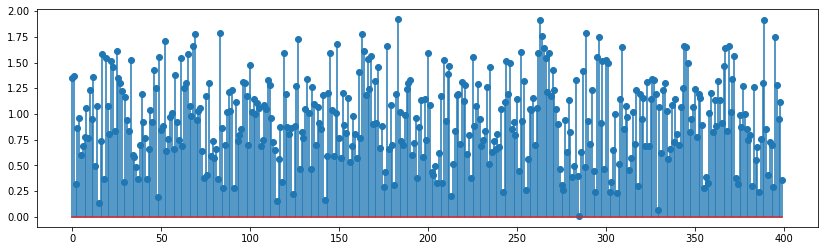

In [23]:
plt.stem(c[0:400]);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


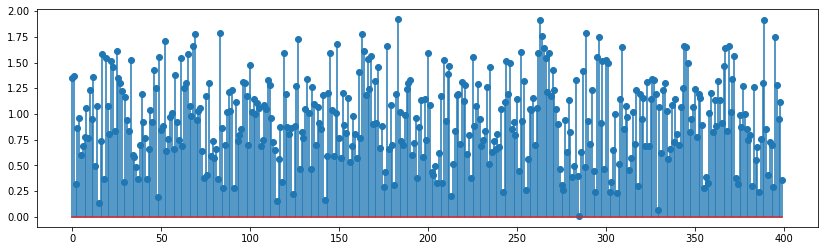

In [24]:
plt.stem(y[0:400]);

In [25]:
(np.sum(y[0:400] - c[0:400]))

0.0